## Dataset

- PASCAL VOC 2007
  - Number of class: 20
  - The data list is provided in the google drive. However, you have to download the training/testing data from http://host.robots.ox.ac.uk/pascal/VOC/voc2007/. 
    - Train/Val data: 5011
        - Each row contains one image and its bounding boxes.
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 0
    - Test data: 4952
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 0
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Transforming data
將random transform 定義在dataset的get_item中，使用data loader時就會transform。

In [ ]:
import os.path

import random
import numpy as np

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import cv2
import matplotlib.pyplot as plt

class yoloDataset(data.Dataset):
    image_size = 448 # Size to be aligned

    # Parsing data list
    def __init__(self,root,list_file,train,transform):
        self.root = root
        self.train = train
        self.transform = transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.mean = (123,117,104) # RGB

        # Cat multiple list files together.
        '''if isinstance(list_file, list):
            # This is especially useful for voc07/voc12 combination.
            tmp_file = '/tmp/listfile.txt'
            os.system('cat %s > %s' % (' '.join(list_file), tmp_file))
            list_file = tmp_file'''

        with open(list_file) as f:
            lines  = f.readlines()

        # format of each line: filename (x_min, y_min, x_max, y_max, label) * object_num
        for line in lines:
            splited = line.strip().split() # .strip(): reomove space, tab from the end of each line
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box=[]
            label=[]
            for i in range(num_boxes):
                x = float(splited[1+5*i])
                y = float(splited[2+5*i])
                x2 = float(splited[3+5*i])
                y2 = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x,y,x2,y2])
                label.append(int(c)+1) # +1: since the idx start from 0
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes)

    # Getting single transformed, preprocessed image and its target
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        # Randomly transforming image
        if self.train:
            #img = self.random_bright(img)
            img, boxes = self.random_flip(img, boxes)
            img,boxes = self.randomScale(img,boxes)
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img,boxes,labels = self.randomShift(img,boxes,labels)
            img,boxes,labels = self.randomCrop(img,boxes,labels)

        # #debug: showing the transformed image
        # box_show = boxes.numpy().reshape(-1)
        # # print(box_show)
        # img_show = self.BGR2RGB(img)
        # pt1=(int(box_show[0]),int(box_show[1])); pt2=(int(box_show[2]),int(box_show[3]))
        # cv2.rectangle(img_show,pt1=pt1,pt2=pt2,color=(0,255,0),thickness=1)
        # plt.figure()
        
        # plt.imshow(img_show)
        # plt.show()
        # #debug

        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes) 
        # .expand_as(other): expand this tensor as other
        # [w, h, w, h] (1, 4) will be expanded to (#box, 4)

        img = self.BGR2RGB(img) # because pytorch pretrained model use RGB
        img = self.subMean(img,self.mean)
        img = cv2.resize(img,(self.image_size,self.image_size))
        target = self.encoder(boxes,labels) # 7x7x30, where 30 = 5*2(xywh+confidence for 2 boxes) + 20(classes)
        for t in self.transform:
            img = t(img)

        return img,target

    def __len__(self):
        return self.num_samples

    # Utils
    # Encoding the boxes, labels for single image
    def encoder(self,boxes,labels):
        grid_num = 14
        target = torch.zeros((grid_num,grid_num,30))
        cell_size = 1./grid_num
        wh = boxes[:,2:]-boxes[:,:2]
        cxcy = (boxes[:,2:]+boxes[:,:2])/2
        for i in range(cxcy.size()[0]):
            cxcy_sample = cxcy[i]
            ij = (cxcy_sample/cell_size).ceil()-1 #
            target[int(ij[1]),int(ij[0]),4] = 1
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            xy = ij*cell_size # upper left coordinates of corresponding grid
            delta_xy = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
        return target

    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    def BGR2HSV(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    def HSV2BGR(self,img):
        return cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    
    def subMean(self,bgr,mean):
        mean = np.array(mean, dtype=np.float32)
        bgr = bgr - mean
        return bgr
    
    def RandomBrightness(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomSaturation(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomHue(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            h = h*adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def randomBlur(self,bgr):
        if random.random()<0.5:
            bgr = cv2.blur(bgr,(5,5))
        return bgr

    def randomShift(self,bgr,boxes,labels):
        center = (boxes[:,2:]+boxes[:,:2])/2
        if random.random() <0.5:
            height,width,c = bgr.shape
            after_shfit_image = np.zeros((height,width,c),dtype=bgr.dtype)
            after_shfit_image[:,:,:] = (104,117,123) #bgr
            shift_x = random.uniform(-width*0.2,width*0.2)
            shift_y = random.uniform(-height*0.2,height*0.2)
            #print(bgr.shape,shift_x,shift_y)
            #原图像的平移
            if shift_x>=0 and shift_y>=0:
                after_shfit_image[int(shift_y):,int(shift_x):,:] = bgr[:height-int(shift_y),:width-int(shift_x),:]
            elif shift_x>=0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),int(shift_x):,:] = bgr[-int(shift_y):,:width-int(shift_x),:]
            elif shift_x <0 and shift_y >=0:
                after_shfit_image[int(shift_y):,:width+int(shift_x),:] = bgr[:height-int(shift_y),-int(shift_x):,:]
            elif shift_x<0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),:width+int(shift_x),:] = bgr[-int(shift_y):,-int(shift_x):,:]

            shift_xy = torch.FloatTensor([[int(shift_x),int(shift_y)]]).expand_as(center)
            center = center + shift_xy
            mask1 = (center[:,0] >0) & (center[:,0] < width)
            mask2 = (center[:,1] >0) & (center[:,1] < height)
            mask = (mask1 & mask2).view(-1,1)
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if len(boxes_in) == 0:
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[int(shift_x),int(shift_y),int(shift_x),int(shift_y)]]).expand_as(boxes_in)
            boxes_in = boxes_in+box_shift
            labels_in = labels[mask.view(-1)]
            return after_shfit_image,boxes_in,labels_in
        return bgr,boxes,labels

    def randomScale(self,bgr,boxes):
        #固定住高度，以0.8-1.2伸缩宽度，做图像形变
        if random.random() < 0.5:
            scale = random.uniform(0.8,1.2)
            height,width,c = bgr.shape
            bgr = cv2.resize(bgr,(int(width*scale),height))
            scale_tensor = torch.FloatTensor([[scale,1,scale,1]]).expand_as(boxes)
            boxes = boxes * scale_tensor
            return bgr,boxes
        return bgr,boxes

    def randomCrop(self,bgr,boxes,labels):
        if random.random() < 0.5:
            center = (boxes[:,2:]+boxes[:,:2])/2
            height,width,c = bgr.shape
            h = random.uniform(0.6*height,height)
            w = random.uniform(0.6*width,width)
            x = random.uniform(0,width-w)
            y = random.uniform(0,height-h)
            x,y,h,w = int(x),int(y),int(h),int(w)

            center = center - torch.FloatTensor([[x,y]]).expand_as(center)
            mask1 = (center[:,0]>0) & (center[:,0]<w)
            mask2 = (center[:,1]>0) & (center[:,1]<h)
            mask = (mask1 & mask2).view(-1,1)

            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if(len(boxes_in)==0):
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[x,y,x,y]]).expand_as(boxes_in)

            boxes_in = boxes_in - box_shift
            boxes_in[:,0]=boxes_in[:,0].clamp_(min=0,max=w)
            boxes_in[:,2]=boxes_in[:,2].clamp_(min=0,max=w)
            boxes_in[:,1]=boxes_in[:,1].clamp_(min=0,max=h)
            boxes_in[:,3]=boxes_in[:,3].clamp_(min=0,max=h)

            labels_in = labels[mask.view(-1)]
            img_croped = bgr[y:y+h,x:x+w,:]
            return img_croped,boxes_in,labels_in
        return bgr,boxes,labels

    def random_flip(self, im, boxes):
        if random.random() < 0.5:
            im_lr = np.fliplr(im).copy()
            h,w,_ = im.shape
            xmin = w - boxes[:,2]
            xmax = w - boxes[:,0]
            boxes[:,0] = xmin
            boxes[:,2] = xmax
            return im_lr, boxes
        return im, boxes

    def random_bright(self, im, delta=16): # unused
        alpha = random.random()
        if alpha > 0.3:
            im = im * alpha + random.randrange(-delta,delta)
            im = im.clip(min=0,max=255).astype(np.uint8)
        return im

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

file_root = '/content/drive/My Drive/Project01_Object-Detection/voc2007/'
list_file = file_root + 'voc2007.txt'

train_dataset = yoloDataset(root=file_root,list_file=list_file,train=True,transform = [transforms.ToTensor()] )
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)

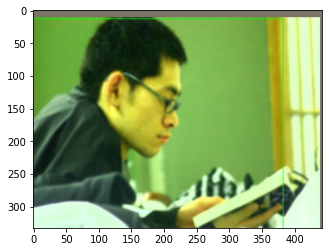

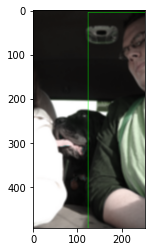

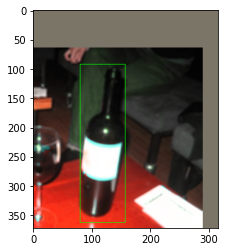

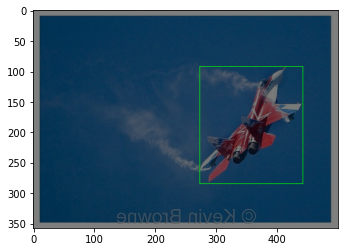

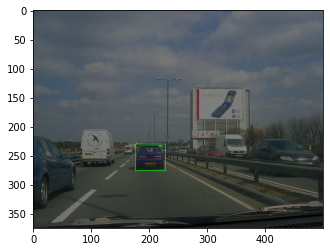

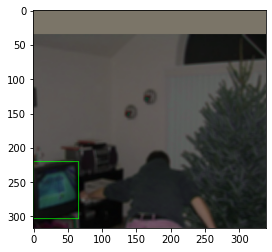

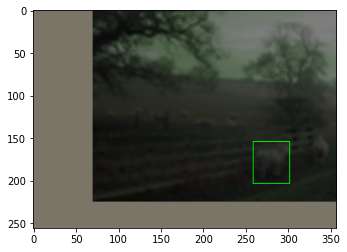

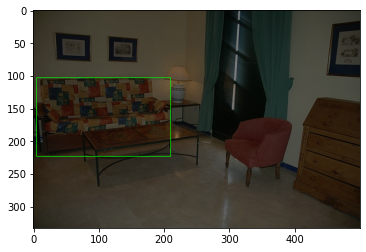

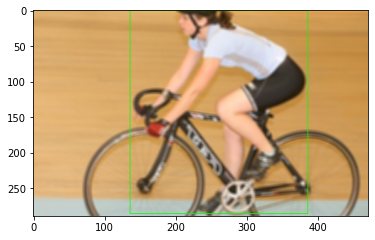

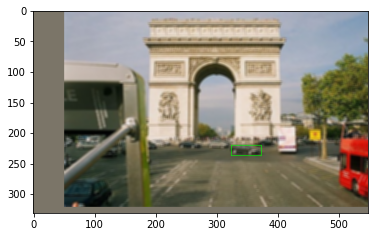

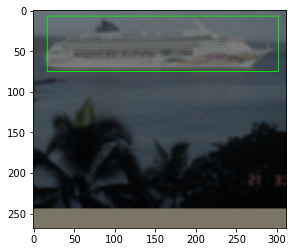

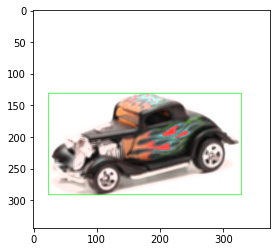

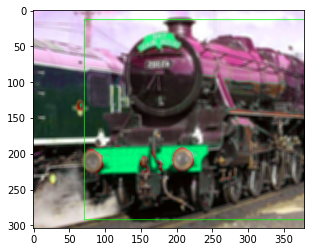

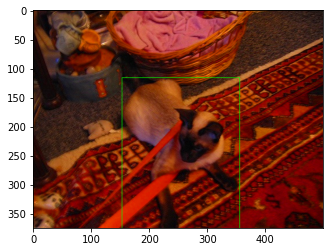

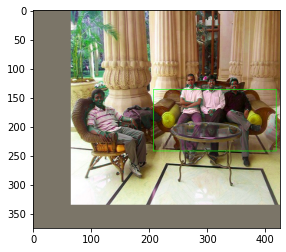

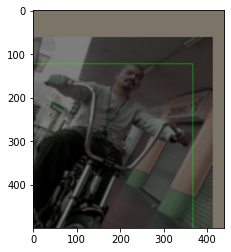

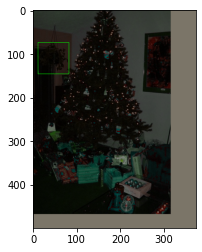

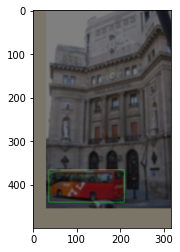

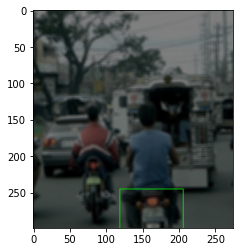

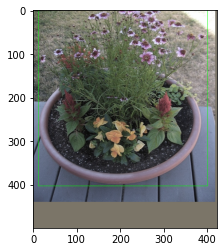

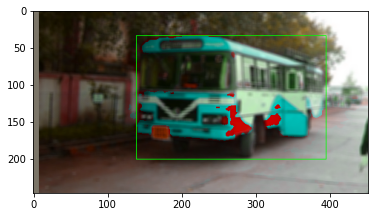

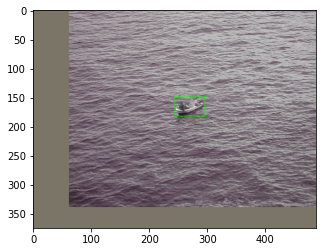

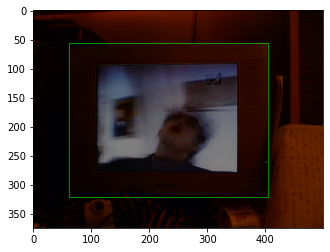

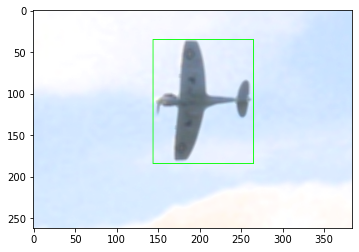

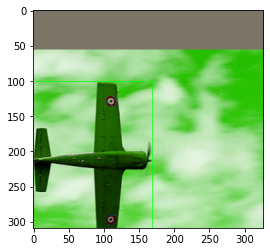

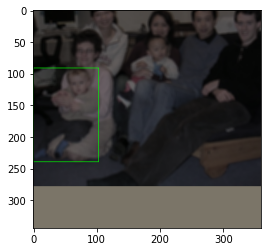

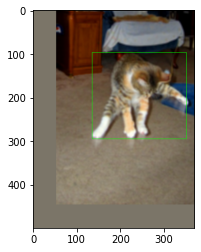

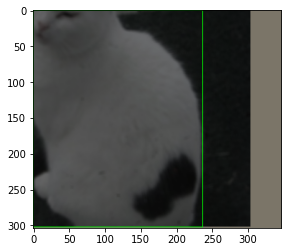

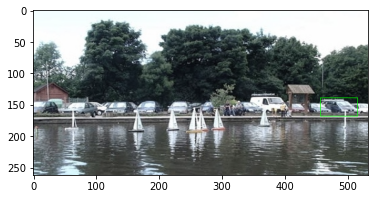

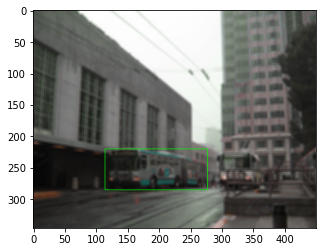

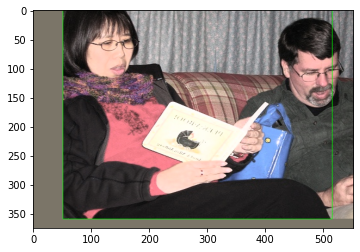

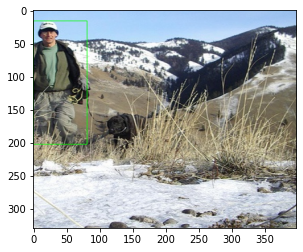

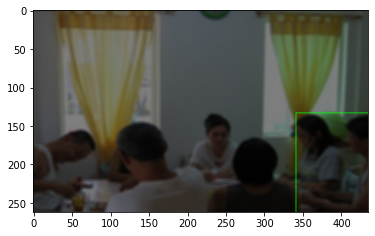

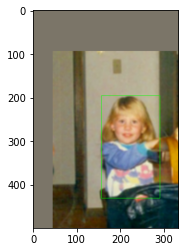

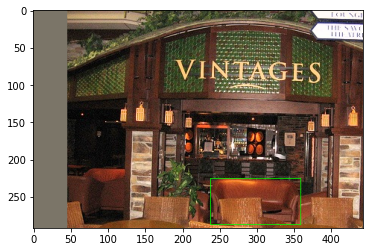

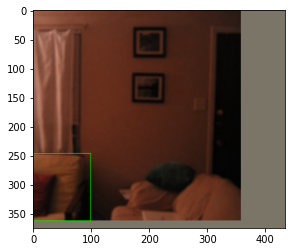

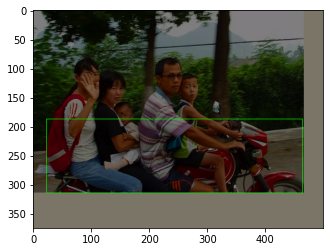

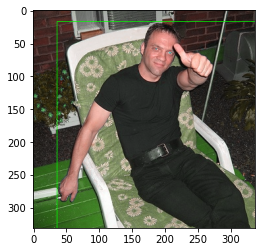

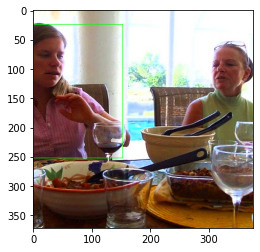

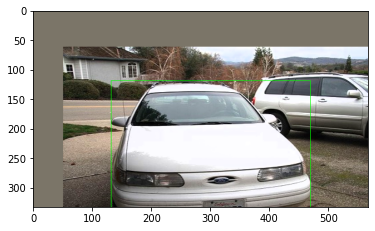

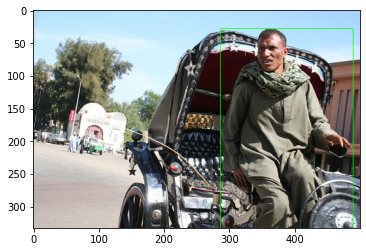

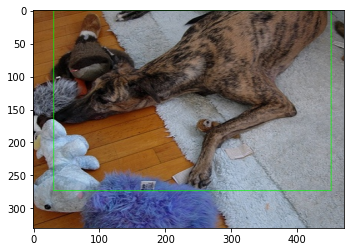

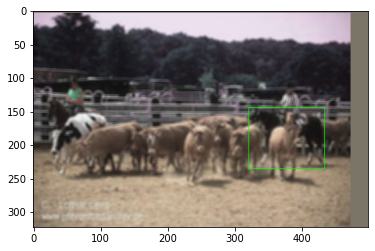

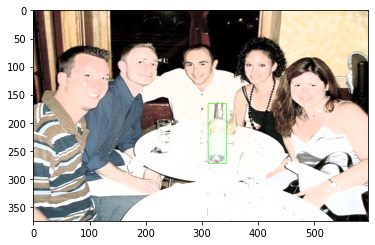

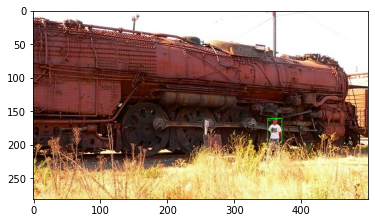

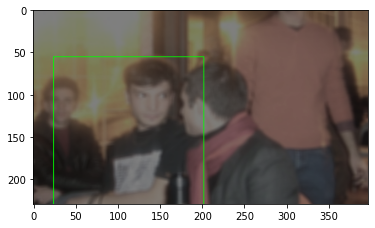

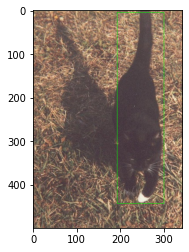

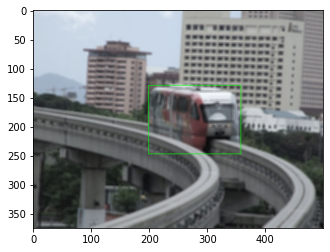

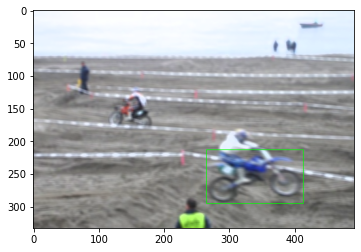

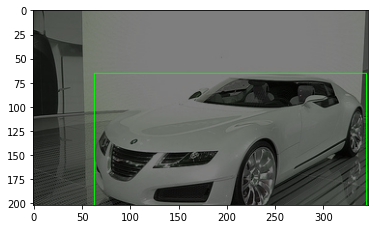

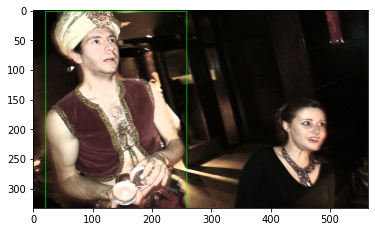

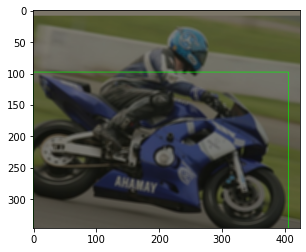

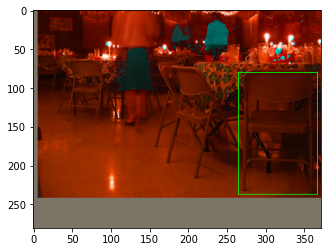

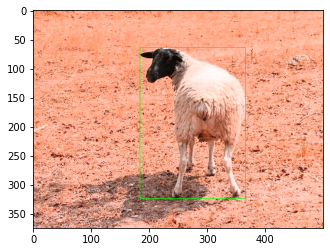

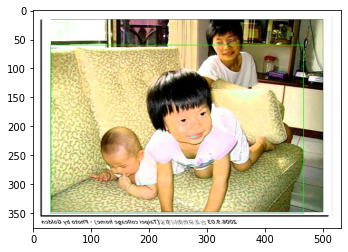

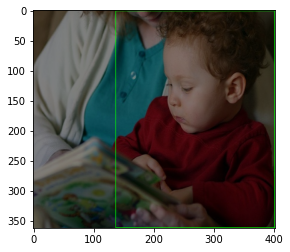

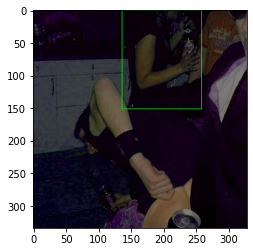

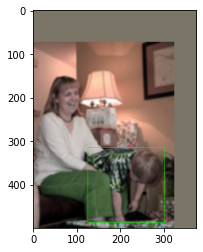

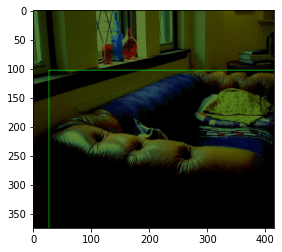

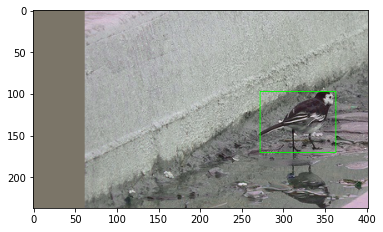

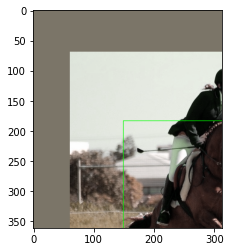

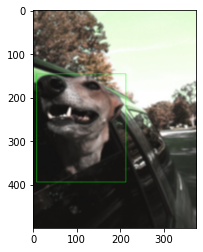

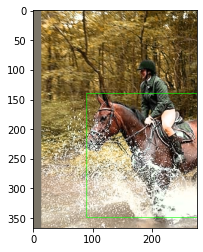

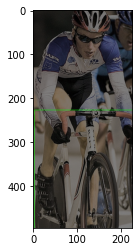

[tensor([[[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           ...,
           [  98.6417,   98.0129,   97.6537,  ...,    0.0000,    0.0000,
               0.0000],
           [  99.0000,   98.0201,   98.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [  99.0000,   98.0201,   98.0000,  ...,    0.0000,    0.0000,
               0.0000]],
 
          [[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
               0.0000],
           ...,
           [ 138.0000,  138.0000,  138.0000,  ...,    0.0000,    0.0000,
               0.00

In [ ]:
# Show the transformed images by uncomment above debug section
next(iter(train_loader))

## Resnet50 backbone

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import model_urls

class ResNetBackbone(nn.Module):

    def __init__(self, resnet_type):
	
        resnet_spec = {18: (BasicBlock, [2, 2, 2, 2], [64, 64, 128, 256, 512], 'resnet18'),
		       34: (BasicBlock, [3, 4, 6, 3], [64, 64, 128, 256, 512], 'resnet34'),
		       50: (Bottleneck, [3, 4, 6, 3], [64, 256, 512, 1024, 2048], 'resnet50'),
		       101: (Bottleneck, [3, 4, 23, 3], [64, 256, 512, 1024, 2048], 'resnet101'),
		       152: (Bottleneck, [3, 8, 36, 3], [64, 256, 512, 1024, 2048], 'resnet152')}
        block, layers, channels, name = resnet_spec[resnet_type]
        
        self.name = name
        self.inplanes = 64
        super(ResNetBackbone, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, mean=0, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # x4 layer output size: (B, 2048, 8, 8)
        return x4

    def init_weights(self):
        org_resnet = torch.utils.model_zoo.load_url(model_urls[self.name])
        # drop orginal resnet fc layer, add 'None' in case of no fc layer, that will raise error
        org_resnet.pop('fc.weight', None)
        org_resnet.pop('fc.bias', None)

        self.load_state_dict(org_resnet)
        print("Initialize resnet from model zoo")

## Evaluating

In [ ]:
'''import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"'''
import numpy as np
VOC_CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train', 'tvmonitor')

In [ ]:
def voc_ap(rec,prec,use_07_metric=False):
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0.,1.1,0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec>=t])
            ap = ap + p/11.

    else:
        # correct ap caculation
        mrec = np.concatenate(([0.],rec,[1.]))
        mpre = np.concatenate(([0.],prec,[0.]))

        for i in range(mpre.size -1, 0, -1):
            mpre[i-1] = np.maximum(mpre[i-1],mpre[i])

        i = np.where(mrec[1:] != mrec[:-1])[0]

        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

def voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES,threshold=0.5,use_07_metric=False,):
    '''
    preds {'cat':[[image_id,confidence,x1,y1,x2,y2],...],'dog':[[],...]}
    target {(image_id,class):[[],]}
    '''
    aps = []
    for i,class_ in enumerate(VOC_CLASSES):
        pred = preds[class_] #[[image_id,confidence,x1,y1,x2,y2],...]
        if len(pred) == 0: #如果这个类别一个都没有检测到的异常情况
            ap = -1
            print('---class {} ap {}---'.format(class_,ap))
            aps += [ap]
            break
        #print(pred)
        image_ids = [x[0] for x in pred]
        confidence = np.array([float(x[1]) for x in pred])
        BB = np.array([x[2:] for x in pred])
        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        npos = 0.
        for (key1,key2) in target:
            if key2 == class_:
                npos += len(target[(key1,key2)]) #统计这个类别的正样本，在这里统计才不会遗漏
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d,image_id in enumerate(image_ids):
            bb = BB[d] #预测框
            if (image_id,class_) in target:
                BBGT = target[(image_id,class_)] #[[],]
                for bbgt in BBGT:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(bbgt[0], bb[0])
                    iymin = np.maximum(bbgt[1], bb[1])
                    ixmax = np.minimum(bbgt[2], bb[2])
                    iymax = np.minimum(bbgt[3], bb[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    union = (bb[2]-bb[0]+1.)*(bb[3]-bb[1]+1.) + (bbgt[2]-bbgt[0]+1.)*(bbgt[3]-bbgt[1]+1.) - inters
                    if union == 0:
                        print(bb,bbgt)
                    
                    overlaps = inters/union
                    if overlaps > threshold:
                        tp[d] = 1
                        BBGT.remove(bbgt) #这个框已经匹配到了，不能再匹配
                        if len(BBGT) == 0:
                            del target[(image_id,class_)] #删除没有box的键值
                        break
                fp[d] = 1-tp[d]
            else:
                fp[d] = 1
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp/float(npos)
        prec = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)
        #print(rec,prec)
        ap = voc_ap(rec, prec, use_07_metric)
        print('---class {} ap {}---'.format(class_,ap))
        aps += [ap]
    print('---map {}---'.format(np.mean(aps)))

In [ ]:
# evaluating the simulated value

preds = {'cat':[['image01',0.9,20,20,40,40],['image01',0.8,20,20,50,50],['image02',0.8,30,30,50,50]],'dog':[['image01',0.78,60,60,90,90]]}
target = {('image01','cat'):[[20,20,41,41]],('image01','dog'):[[60,60,91,91]],('image02','cat'):[[30,30,51,51]]}
voc_eval(preds,target,VOC_CLASSES=['cat','dog'])

# test & eval model
'''from predict import *
from collections import defaultdict
from tqdm import tqdm

target =  defaultdict(list)
preds = defaultdict(list)
image_list = [] #image path list

f = open('voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()
print('---prepare target---')
for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])
#
#start test
#
print('---start test---')
model = resnet50()
model.load_state_dict(torch.load('best.pth'))
model.eval()
model.cuda()
count = 0
for image_path in tqdm(image_list):
    result = predict_gpu(model,image_path,root_path='/home/xzh/data/VOCdevkit/VOC2012/allimgs/') #result[[left_up,right_bottom,class_name,image_path],]
    for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
    # print(image_path)
    # image = cv2.imread('/home/xzh/data/VOCdevkit/VOC2012/allimgs/'+image_path)
    # for left_up,right_bottom,class_name,_,prob in result:
    #     color = Color[VOC_CLASSES.index(class_name)]
    #     cv2.rectangle(image,left_up,right_bottom,color,2)
    #     label = class_name+str(round(prob,2))
    #     text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    #     p1 = (left_up[0], left_up[1]- text_size[1])
    #     cv2.rectangle(image, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
    #     cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, 8)

    # cv2.imwrite('testimg/'+image_path,image)
    # count += 1
    # if count == 100:
    #     break
    
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES)'''

---class cat ap 0.8333333333333333---
---class dog ap 1.0---
---map 0.9166666666666666---


"from predict import *\nfrom collections import defaultdict\nfrom tqdm import tqdm\n\ntarget =  defaultdict(list)\npreds = defaultdict(list)\nimage_list = [] #image path list\n\nf = open('voc2007test.txt')\nlines = f.readlines()\nfile_list = []\nfor line in lines:\n    splited = line.strip().split()\n    file_list.append(splited)\nf.close()\nprint('---prepare target---')\nfor index,image_file in enumerate(file_list):\n    image_id = image_file[0]\n\n    image_list.append(image_id)\n    num_obj = (len(image_file) - 1) // 5\n    for i in range(num_obj):\n        x1 = int(image_file[1+5*i])\n        y1 = int(image_file[2+5*i])\n        x2 = int(image_file[3+5*i])\n        y2 = int(image_file[4+5*i])\n        c = int(image_file[5+5*i])\n        class_name = VOC_CLASSES[c]\n        target[(image_id,class_name)].append([x1,y1,x2,y2])\n#\n#start test\n#\nprint('---start test---')\nmodel = resnet50()\nmodel.load_state_dict(torch.load('best.pth'))\nmodel.eval()\nmodel.cuda()\ncount = 0\nfor ima

## Visualizing

In [1]:
import cv2

Color = [[0, 0, 0],[128, 0, 0],[0, 128, 0],[128, 128, 0],
      [0, 0, 128],[128, 0, 128],[0, 128, 128],[128, 128, 128],
      [64, 0, 0],[192, 0, 0],[64, 128, 0],[192, 128, 0],
      [64, 0, 128],[192, 0, 128],[64, 128, 128],[192, 128, 128],
      [0, 64, 0],[128, 64, 0],[0, 192, 0],[128, 192, 0],[0, 64, 128]]

def visualize_boxes(image, result):
  for left_up,right_bottom,class_name,_,prob in result:
    # Draw box
    color = Color[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, thickness=2)

    # Draw text
    label = class_name + str(round(prob,2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4, thickness=1)

    p1 = (left_up[0], left_up[1]- text_size[1])

    cv2.rectangle(image, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, 8)
  return image

In [ ]:
# Main function

model = ???
model.eval()
model.cuda()

image_name = ???
image = cv2.imread(image_name)

result = predict_gpu(model, image_name)
result_image = visualize_boxes(image, result)
cv2.imwrite('result.jpg', result_image)

## Assignment
You are required to build a model to perform object detection on the provided Pascal VOC dataset in this project.
Here are some hints that help you to accomplish the project successfully.

### Hints
- YOLOv1 is the simplest and suggested model to be implemented.
- Be careful of the normalization techniques on bounding boxes.
    1. normalize the height and width with image size to fall into 0 and 1
    2. x and y coordinates are parameterized to be the offsets of a particular grid cell and also bounded by 0 and 1
- Loss function has a great impact on training stability.
    1. loss function is the most important in this project, especially in calculating IOU
    2. only one bounding box predictor is responsible for each object
    3. weights for different types of losses
    4. predict the square root of height and width instead of predicting them directly
- Data augmentation.
    1. It contains only 5011 images in total. Furthermore, the labels are highly imbalanced.
    2. Random scaling and translations are applied when training YOLO.
    3. Note that the bounding box coordinates have to be changed accordingly if the image was transformed.

### Evaluation Metric
- Please evaluate your model on Pascal VOC testing set using Mean Average Precision (mAP).
- Write a brief report including your implementation, performance and  qualitative results(visualize bounding box on some images). 
- For more detailed explanation of mAP, please follow https://github.com/rafaelpadilla/Object-Detection-Metrics